# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

### Homework 1 is due 2/13

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
import os
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from sklearn.preprocessing import PolynomialFeatures
r_utils = importr('utils')
# if there are errors about missing R packages, uncomment and run the lines below:
# r_utils.install_packages('codetools')
# r_utils.install_packages('gam')
r_splines = importr('splines')
r_smooth_spline = robjects.r['smooth.spline'] #extract R function
r_gam_lib = importr('gam')
r_gam = r_gam_lib.gam #extract R function
r_glm = robjects.r['glm'] #extract R function
r_anova = robjects.r['anova'] #extract R function
import seaborn as sns
from sklearn.metrics import r2_score


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for Airbnb units in the Boston area from 2017 to 2018. Note that some of the rows in the `.csv` file refer to dates in the future. These refer to bookings that have been made far in advance.

Start by loading the data using pandas:

In [3]:
calendar_train = pd.read_csv('calendar_train.csv')
calendar_test = pd.read_csv('calendar_test.csv')

In [4]:
display(calendar_train.head())
display(calendar_test.head())

,listing_id,date,available,price
0,20872145,9/21/18,f,NaN
1,20872145,9/19/18,f,NaN
2,20872145,9/18/18,f,NaN
3,20872145,9/17/18,f,NaN
4,20872145,9/16/18,f,NaN


,listing_id,date,available,price
0,21205442,9/28/18,t,138.0
1,5166870,8/11/18,t,210.0
2,9698823,10/17/17,f,NaN
3,18894466,2/21/18,f,NaN
4,6765855,9/22/18,f,NaN


In [5]:
# drop na's
calendar_train.dropna(axis=0, inplace=True)
calendar_test.dropna(axis=0, inplace=True)

In [6]:
display(calendar_train.head())
display(calendar_train.head())

,listing_id,date,available,price
123,20872145,4/2/18,t,62.0
124,20872145,4/1/18,t,59.0
125,20872145,3/31/18,t,75.0
126,20872145,3/30/18,t,71.0
127,20872145,3/28/18,t,51.0


,listing_id,date,available,price
123,20872145,4/2/18,t,62.0
124,20872145,4/1/18,t,59.0
125,20872145,3/31/18,t,75.0
126,20872145,3/30/18,t,71.0
127,20872145,3/28/18,t,51.0


### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

*Hint*: You will want to first convert the `date` column into Python dates using `datetime.datetime.strptime(arg1,arg2).date()` and providing the appropriate arguments.

In [7]:
# date format 
# train
calendar_train['date'] = calendar_train['date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y').date())
calendar_train['weekday'] = calendar_train['date'].apply(lambda x: x.weekday())
calendar_train['Month'] = calendar_train['date'].apply(lambda x: x.month)

# test
calendar_test['date'] = calendar_test['date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y').date())
calendar_test['weekday'] = calendar_test['date'].apply(lambda x: x.weekday())
calendar_test['Month'] = calendar_test['date'].apply(lambda x: x.month)

In [8]:
# group them 
gb_month = calendar_train.groupby('Month')['price'].mean()
gb_weekday = calendar_train.groupby('weekday')['price'].mean()
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
weekdays = ['Mon','Tue','Wed', 'Thu','Fri','Sat','Sun']

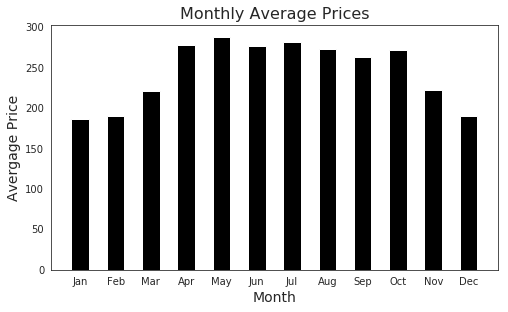

In [9]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.bar(gb_month.index.values, gb_month.values, width=0.5, color = 'k')
    ax.set_xticks(gb_month.index.values)
    ax.set_xticklabels(months)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('Avergage Price', fontsize=14)    
    ax.set_title('Monthly Average Prices', fontsize=16)

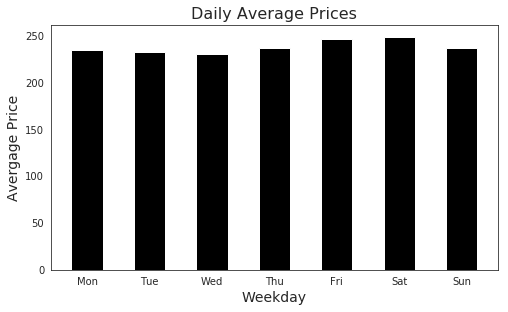

In [10]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.bar(gb_weekday.index.values, gb_weekday.values, width=0.5, color = 'k')
    ax.set_xticks(gb_weekday.index.values)
    ax.set_xticklabels(weekdays)
    ax.set_xlabel('Weekday', fontsize=14)
    ax.set_ylabel('Avergage Price', fontsize=14)    
    ax.set_title('Daily Average Prices', fontsize=16)

In the plot of monthly average prices, we see slighlty higher prices for the warmer months, which makes sense as we would expect more tourism perhaps during the warmer months. 

In the plot of daily average prices, we see a roughly uniform distribution of price across the days of the week. We see every so slighlty higher prics towards the end of the week - Thursday to Saturday. Intuitively, this makes sense as people in search of a place to see are most likely visiting and the preformed time to visit would most likely be towards the end of the weekday when people might be off work or away froms chool.

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the average price of an Airbnb rental on that date. For this part of the question, you can ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Regression models with different basis functions:
    * Simple polynomials with degrees 5, 25, and 50
    * Cubic B-splines with the knots chosen by visual inspection of the data
    * Natural cubic splines with the degree of freedom chosen by cross-validation on the training set.
    
2. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

In each case, analyze the effect of the relevant tuning parameters on the training and test $R^2$ and give explanations for what you observe.

Is there a reason you would prefer one of these methods over the other (hint: you may want to consider $R^2$)?

*Hint*: The functions `bs` (for B-spline basis functions) and `ns` (for natural cubic spline basis functions) are available  in the `r_splines` library.


#### There seems to be disagreement to what "average" means. I'm taking the strict apporach of using all thousands of data points as Prof. Glickman stated in his Piazza post. 

#### Linear regression with polynomial terms

In [11]:
# grab time for regression
# train
start_date = calendar_train['date'].min()
calendar_train['date_s'] = calendar_train['date'].apply(lambda x: (x-start_date).days)

# test
calendar_test['date_s'] = calendar_test['date'].apply(lambda x: (x-start_date).days)

# sort by the date_s = date standardized to the first entry
calendar_test = calendar_test.sort_values('date_s')

In [2]:
# create r objects
r_lm = robjects.r["lm"]
r_predict = robjects.r["predict"]

In [13]:
def plot_poly_r(degree, x_train, y_train, x_test, y_test, r_sap):
    
    # create r vectors
    r_x = robjects.FloatVector(x_train)
    r_y = robjects.FloatVector(y_train)
    
    # nth degree poly regression
    string_r = "y~poly(x,{}, raw=TRUE)".format(degree)
    poly_formula = robjects.Formula(string_r)
    poly_formula.environment["x"] = r_x
    poly_formula.environment["y"] = r_y
    poly_lm = r_lm(formula=poly_formula)
    
    # create r vectors
    r_x_test = robjects.FloatVector(x_test)
    r_y_test = robjects.FloatVector(y_test)
    
    # predict
    predict_df = robjects.DataFrame({"x": r_x_test})
    predictions = r_predict(poly_lm, predict_df)
    
    r2score = r2_score(r_y_test, predictions)
    
    print('R2 Score: {:.5f}'.format(r2score))
    
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 1, figsize=(16, 9))
        ax.scatter(x_test[r_sap], y_test[r_sap], color = 'red', label = 'Data')
        ax.plot(x_test[r_sap], np.array(predictions)[r_sap], color = 'k', label = 'Predictions', linewidth=4)
        ax.set_xlabel('Day', fontsize=14)
        ax.set_ylabel('Price', fontsize=14)
        ax.set_title('Poly Regressionw with Degree {}'.format(degree), fontsize=16)
        ax.legend()
    return(r2_score)

# random sample to plot
r_sap = np.sort(np.random.choice(calendar_test.shape[0],replace=False,size=2000))

Plot below of degree 5

(as per above, the plot shows a random sample of the data as there are two many points otherwise)

R2 Score: 0.04174


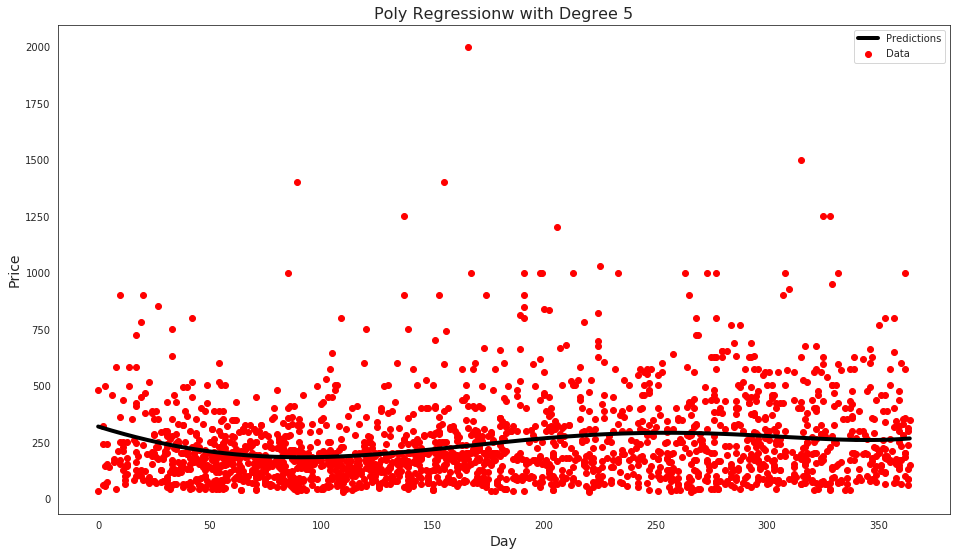

In [14]:
plot_poly_r(5, calendar_train['date_s'].values, 
            calendar_train['price'].values, 
            calendar_test['date_s'].values, 
            calendar_test['price'].values, r_sap);

Plot below of degree 25

##### (as per the function and suggestion on Piazza, plot shows a random sample of the data as there are two many points otherwise)

R2 Score: 0.04355


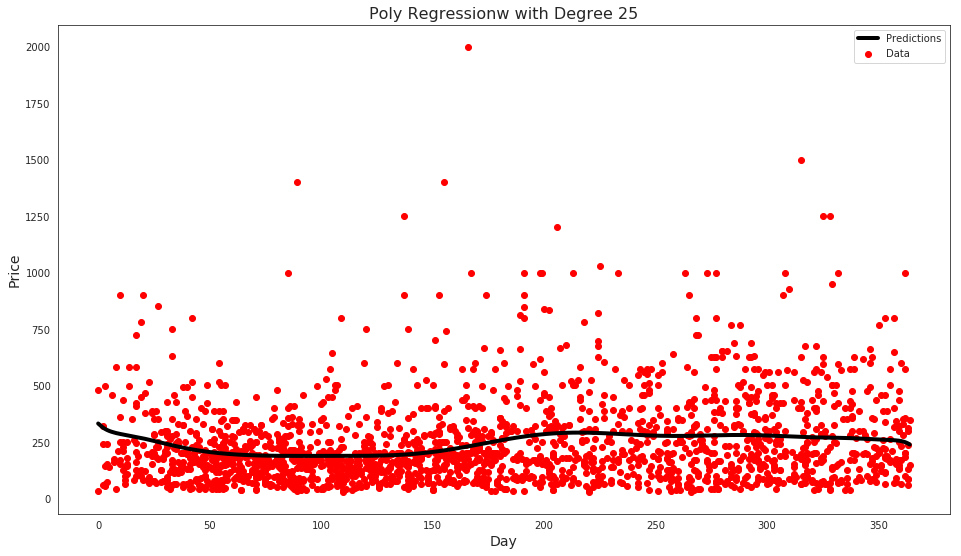

In [15]:
plot_poly_r(25, calendar_train['date_s'].values, 
            calendar_train['price'].values, 
            calendar_test['date_s'].values, 
            calendar_test['price'].values, r_sap);

Plot below of degree 50

R2 Score: 0.04412


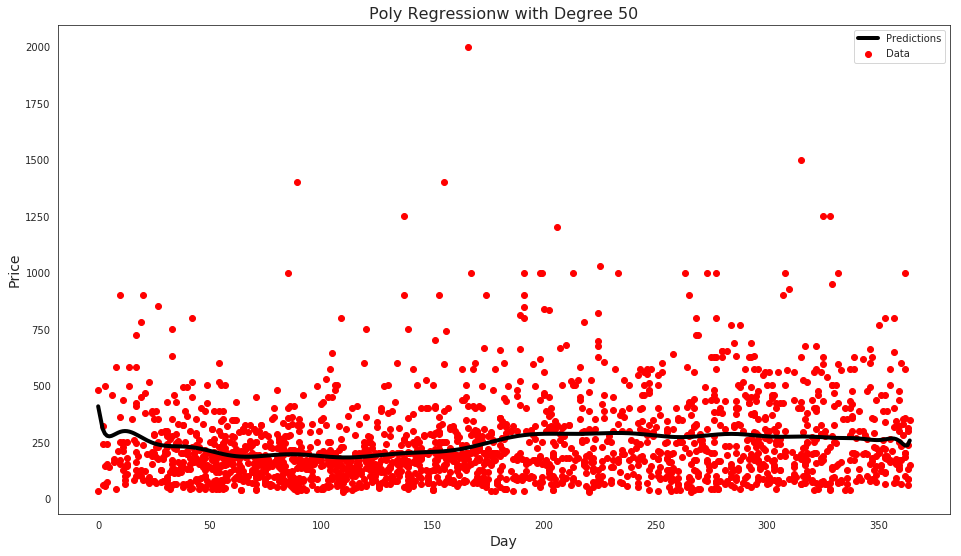

In [16]:
plot_poly_r(50, calendar_train['date_s'].values, 
            calendar_train['price'].values, 
            calendar_test['date_s'].values, 
            calendar_test['price'].values, r_sap);

#### Move onto splines

In [17]:
# vectors 
r_x = robjects.FloatVector(calendar_train['date_s'].values)
r_y = robjects.FloatVector(calendar_train['price'].values)
r_x_test = robjects.FloatVector(calendar_test['date_s'].values)
r_y_test = robjects.FloatVector(calendar_test['price'].values)

#### Cubic B Splines

In [18]:
# import 
r_splines = importr('splines')

In [19]:
# knots - inspection at the following quantiles 
r_knots = robjects.FloatVector(np.quantile(r_x,[.2,.4,.6,.8]))

# populate the formula
bs_formula = robjects.Formula("price ~ bs(dates, knots=r_knots)")
bs_formula.environment['price'] = r_y
bs_formula.environment['dates'] = r_x
bs_formula.environment['r_knots'] = r_knots
         
# fit the model
bs_model = r_lm(bs_formula)

# predict
predict_frame = robjects.DataFrame({"dates": r_x_test})
bs_pred = r_predict(bs_model, predict_frame)
bs_r2score = r2_score(r_y_test, bs_pred)
print(bs_r2score)

0.042945983560548684


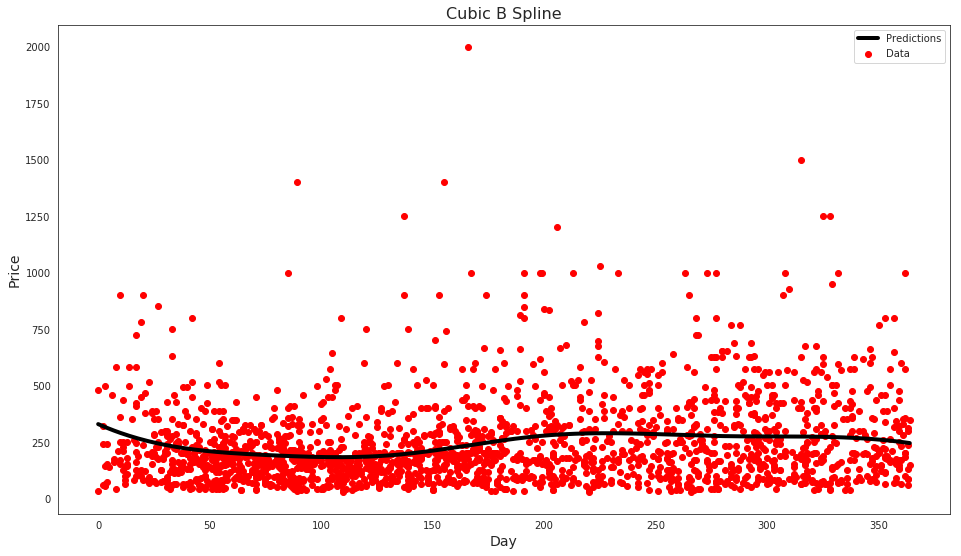

In [25]:
# plot it 
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    ax.scatter(np.array(r_x_test)[r_sap], np.array(r_y_test)[r_sap], color = 'red', label = 'Data')
    ax.plot(np.array(r_x_test)[r_sap], np.array(bs_pred)[r_sap], color = 'k', label = 'Predictions', linewidth=4)
    ax.set_xlabel('Day', fontsize=14)
    ax.set_ylabel('Price', fontsize=14)
    ax.set_title('Cubic B Spline', fontsize=16)
    ax.legend()

#### Natural Cubic Spline

In [2]:
from sklearn.model_selection import KFold

In [23]:
# cross validation to find the number of knots 
knots = [1,2,3,4,5,6,7,8,9,10]
kf = KFold(n_splits=5) 
d_n = {}
for n in knots:
    scores = []
    for train, test in kf.split(r_x):
        # populate the formula
        ns_formula = robjects.Formula("price ~ ns(dates, df=n)")
        ns_formula.environment['price'] = robjects.FloatVector(np.array(r_y)[train])
        ns_formula.environment['dates'] = robjects.FloatVector(np.array(r_x)[train])
        ns_formula.environment['n'] = n

        # fit the model
        ns_model = r_lm(ns_formula)

        # predict
        predict_frame = robjects.DataFrame({"dates": robjects.FloatVector(np.array(r_x)[test])})
        ns_pred = r_predict(ns_model, predict_frame)
        
        # score 
        r2score = r2_score(robjects.FloatVector(np.array(r_y)[test]), ns_pred)
        scores.append(r2score)
        
    #append mean
    d_n[n] = np.mean(scores)

In [22]:
# refit with chosen n
# populate the formula
n = max(d_n, key=d_n.get)
ns_formula = robjects.Formula("price ~ ns(dates, df=n)")
ns_formula.environment['price'] = r_y
ns_formula.environment['dates'] = r_x
ns_formula.environment['n'] = n

# fit the model
ns_model = r_lm(ns_formula)

# predict
predict_frame = robjects.DataFrame({"dates": r_x_test})
ns_pred = r_predict(ns_model, predict_frame)

# score 
ns_r2score = r2_score(r_y_test, ns_pred)
print(ns_r2score)

0.04408375230881567


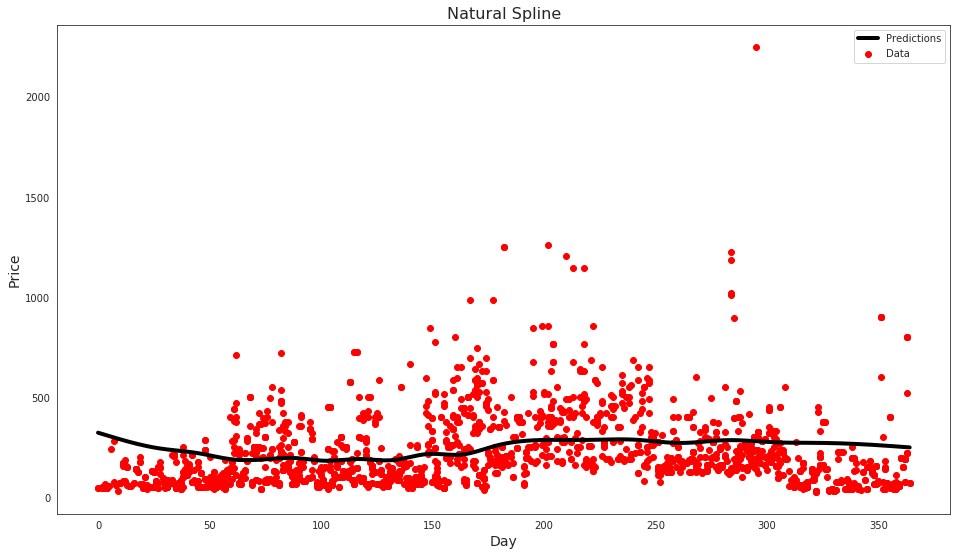

In [23]:
# plot it 
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    ax.scatter(np.array(r_x_test)[r_sap], np.array(r_y_test)[r_sap], color = 'red', label = 'Data')
    ax.plot(np.array(r_x_test)[r_sap], np.array(ns_pred)[r_sap], color = 'k', label = 'Predictions', linewidth=4)
    ax.set_xlabel('Day', fontsize=14)
    ax.set_ylabel('Price', fontsize=14)
    ax.set_title('Natural Spline', fontsize=16)
    ax.legend()

#### Smoothing Spline

In [58]:
r_smooth_spline = robjects.r['smooth.spline']
spline_cv = r_smooth_spline(r_x, r_y, cv=True) 
# predict
predict_frame = robjects.DataFrame({"dates": r_x_test})
smooth_pred = r_predict(spline_cv, predict_frame)
smooth_r2_score = r2_score(r_y_test, np.array(smooth_pred[1]).reshape(-1))
print(smooth_r2_score)

0.05161960263234033


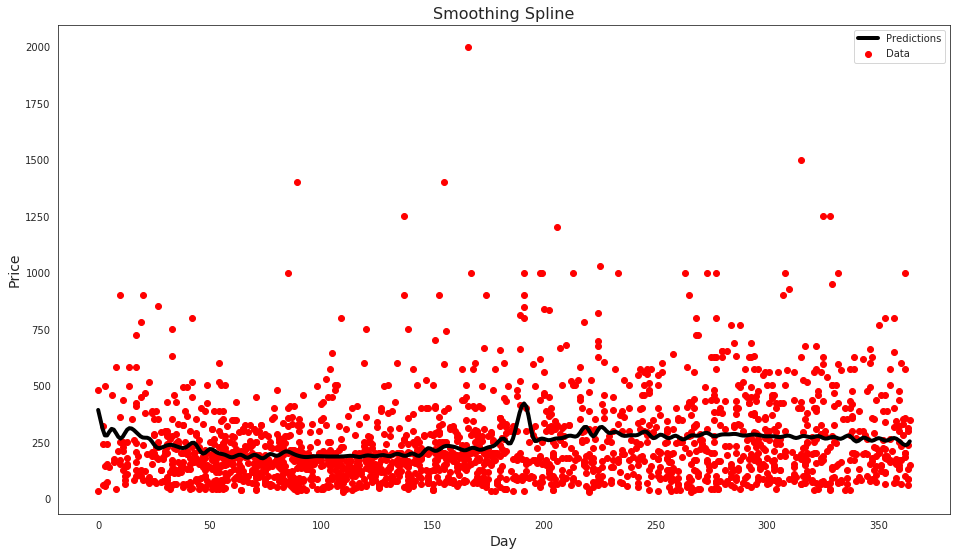

In [40]:
# plot it 
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    ax.scatter(np.array(r_x_test)[r_sap], np.array(r_y_test)[r_sap], color = 'red', label = 'Data')
    ax.plot(np.array(smooth_pred[0]).reshape(-1)[r_sap], np.array(smooth_pred[1]).reshape(-1)[r_sap], color = 'k', label = 'Predictions', linewidth=4)
    ax.set_xlabel('Day', fontsize=14)
    ax.set_ylabel('Price', fontsize=14)
    ax.set_title('Smoothing Spline', fontsize=16)
    ax.legend()

We see from the above models that they all actually have really low R2 values. Intuitively, this makes sense as the data is "wide' i.e. variabile. The data is relatively flat when on the dependent variable of day but is very variable in the y direction - independent variable - of the price. This makes sense as it very difficult to predict the price of an Airbnb stay from just the day. We need more informationa and more variables to regress on because in the above approach we are not at all distinguishing between an Airbnb stay that is an entire home in boston or a stay in a very small bedroom. We would imagine that these two scenarios would explain a lot of the difference in the price. Ultimately, the above regressions are poor because we do not have enough informaiton to go on from just the day. 

### Part 1b: Adapting to weekends

Does the pattern of Airbnb pricing differ over the days of the week? Are the patterns on weekends different from those on weekdays? If so, we might benefit from using a different regression model for weekdays and weekends. Split the training and test data into two parts, one for weekdays and one for weekends, and fit a separate model for each training subset. Do the models yield a higher $R^2$ on the corresponding test subsets compared to the model fitted previously?

In [48]:
# friday night = 4, saturday night =5 
train_weekend_msk = (calendar_train['weekday'] == 4) | (calendar_train['weekday'] == 5)
test_weekend_msk = (calendar_test['weekday'] == 4) | (calendar_test['weekday'] == 5)

In [49]:
# no plot this time
def poly_r(degree, x_train, y_train, x_test, y_test):
    
    # create r vectors
    r_x = robjects.FloatVector(x_train)
    r_y = robjects.FloatVector(y_train)
    
    # nth degree poly regression
    string_r = "y~poly(x,{}, raw=TRUE)".format(degree)
    poly_formula = robjects.Formula(string_r)
    poly_formula.environment["x"] = r_x
    poly_formula.environment["y"] = r_y
    poly_lm = r_lm(formula=poly_formula)
    
    # create r vectors
    r_x_test = robjects.FloatVector(x_test)
    r_y_test = robjects.FloatVector(y_test)
    
    # predict
    predict_df = robjects.DataFrame({"x": r_x_test})
    predictions = r_predict(poly_lm, predict_df)
    
    r2score = r2_score(r_y_test, predictions)
    
    print('R2 Score: {:.5f}'.format(r2score))

#### Weekend Regressions

In [50]:
# degree 5
poly_r(5, np.array(r_x)[train_weekend_msk], 
            np.array(r_y)[train_weekend_msk], 
            np.array(r_x_test)[test_weekend_msk], 
            np.array(r_y_test)[test_weekend_msk]);

R2 Score: 0.04486


In [52]:
# degree 25
poly_r(25, np.array(r_x)[train_weekend_msk], 
            np.array(r_y)[train_weekend_msk], 
            np.array(r_x_test)[test_weekend_msk], 
            np.array(r_y_test)[test_weekend_msk]);

R2 Score: 0.04753


In [53]:
# degree 50
poly_r(50, np.array(r_x)[train_weekend_msk], 
            np.array(r_y)[train_weekend_msk], 
            np.array(r_x_test)[test_weekend_msk], 
            np.array(r_y_test)[test_weekend_msk]);

R2 Score: 0.04826


#### Weekday Regressions

In [54]:
# degree 5
poly_r(5, np.array(r_x)[~train_weekend_msk], 
            np.array(r_y)[~train_weekend_msk], 
            np.array(r_x_test)[~test_weekend_msk], 
            np.array(r_y_test)[~test_weekend_msk]);

R2 Score: 0.04102


In [55]:
# degree 25
poly_r(25, np.array(r_x)[~train_weekend_msk], 
            np.array(r_y)[~train_weekend_msk], 
            np.array(r_x_test)[~test_weekend_msk], 
            np.array(r_y_test)[~test_weekend_msk]);

R2 Score: 0.04243


In [56]:
# degree 50
poly_r(50, np.array(r_x)[~train_weekend_msk], 
            np.array(r_y)[~train_weekend_msk], 
            np.array(r_x_test)[~test_weekend_msk], 
            np.array(r_y_test)[~test_weekend_msk]);

R2 Score: 0.04293


We see from comparing the above with the previous regressions that we obtainslighlty better R2 values for the regressions on the weekends. 

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 3 most expensive dates. Given what you know about Boston, how might you explain why these 3 days happen to be so expensive?

In [69]:
display(calendar_train.groupby('date').mean().sort_values('price', ascending=False).iloc[:5,:])

,listing_id,price,weekday,Month,date_s
date,,,,,
2018-04-14,1.133490e+07,432.680761,5.0,4.0,190.0
2018-04-16,1.132853e+07,425.289528,0.0,4.0,192.0
2018-04-15,1.097488e+07,417.170404,6.0,4.0,191.0
2017-10-07,1.258238e+07,409.298701,5.0,10.0,1.0
2018-04-13,1.133951e+07,393.609047,4.0,4.0,189.0


The top three dates correspond to spring, and the Boston marathon - so lots of visitors looking to book a rooom. 

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [3]:
listings_train = pd.read_csv('listings_train.csv')
listings_test = pd.read_csv('listings_test.csv')
display(listings_train.head())
display(listings_test.head())

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38
2,6,Entire home/apt,42.341902,-71.073792,1.0,1,1,67,45,56,322,9
3,1,Entire home/apt,42.319235,-71.105016,2.0,2,2,103,8,113,341,49
4,1,Entire home/apt,42.346452,-71.134896,1.0,0,1,8,24,82,41,13


,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,3,Private room,42.280279,-71.135870,2.5,1,1,271,2,2,286,17
1,1,Private room,42.285603,-71.144647,1.0,1,1,290,1,1,0,3
2,1,Private room,42.274408,-71.125294,1.0,1,3,62,1,82,240,3
3,1,Entire home/apt,42.287974,-71.129771,2.0,2,2,55,27,74,115,5
4,1,Private room,42.276913,-71.128233,1.5,1,1,326,1,1,361,27


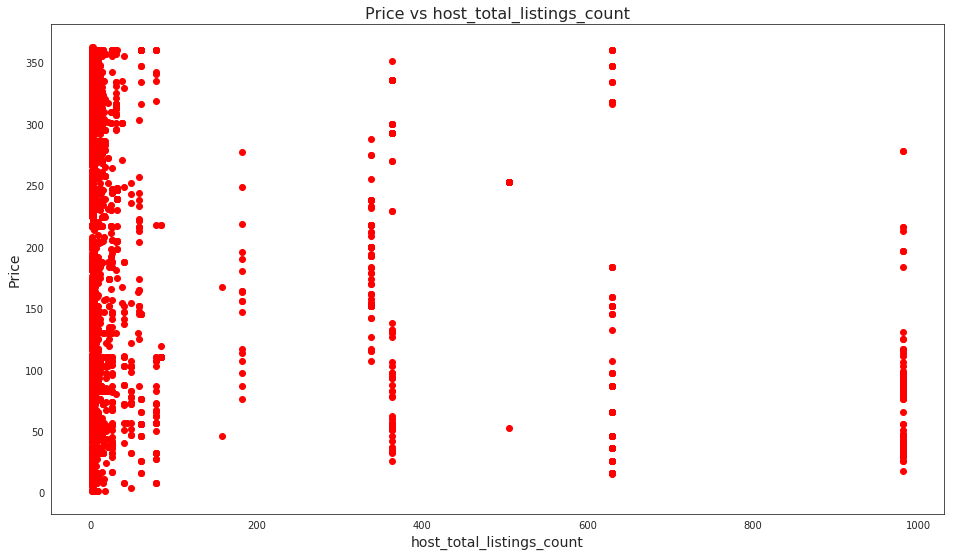

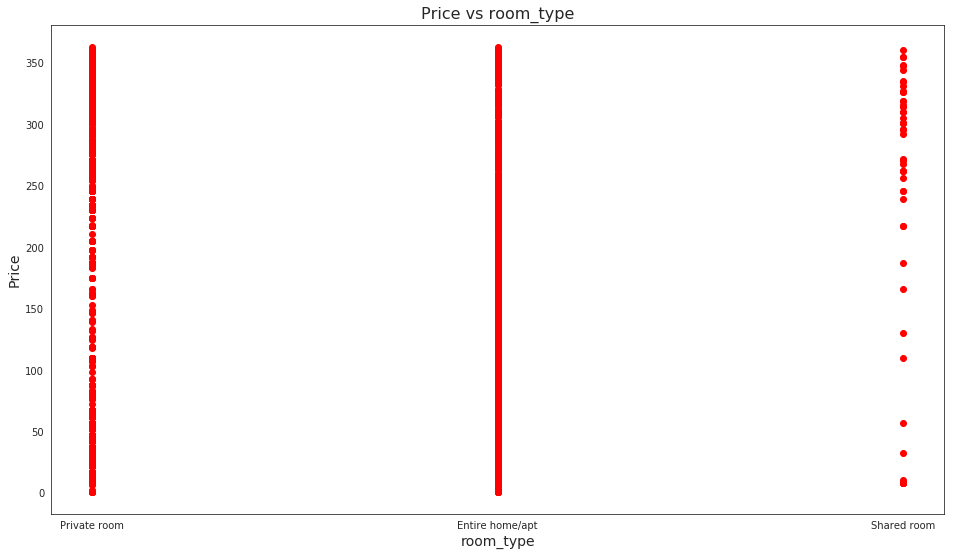

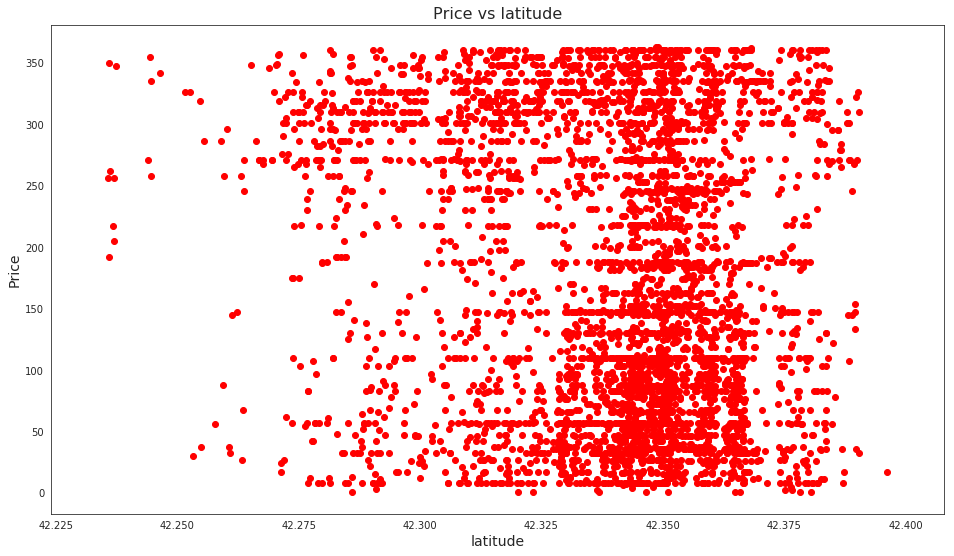

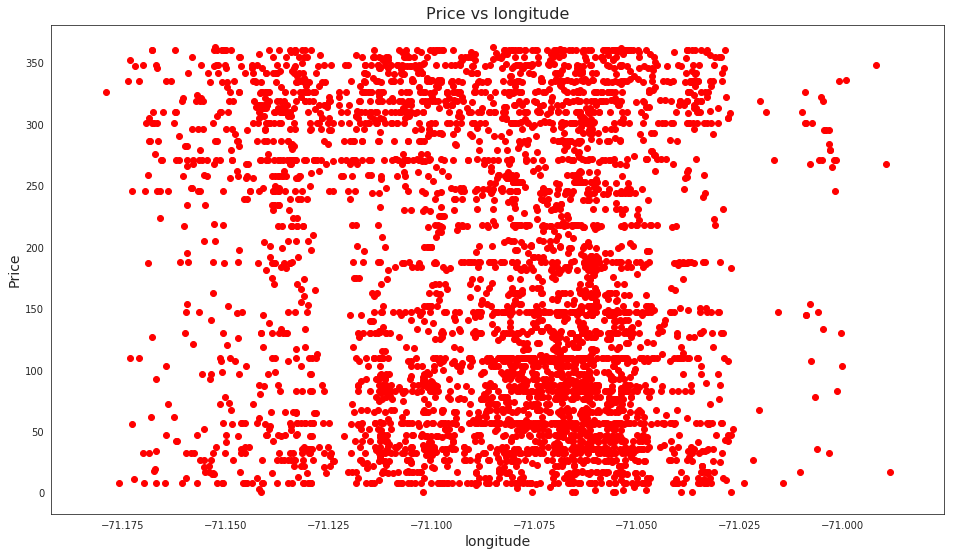

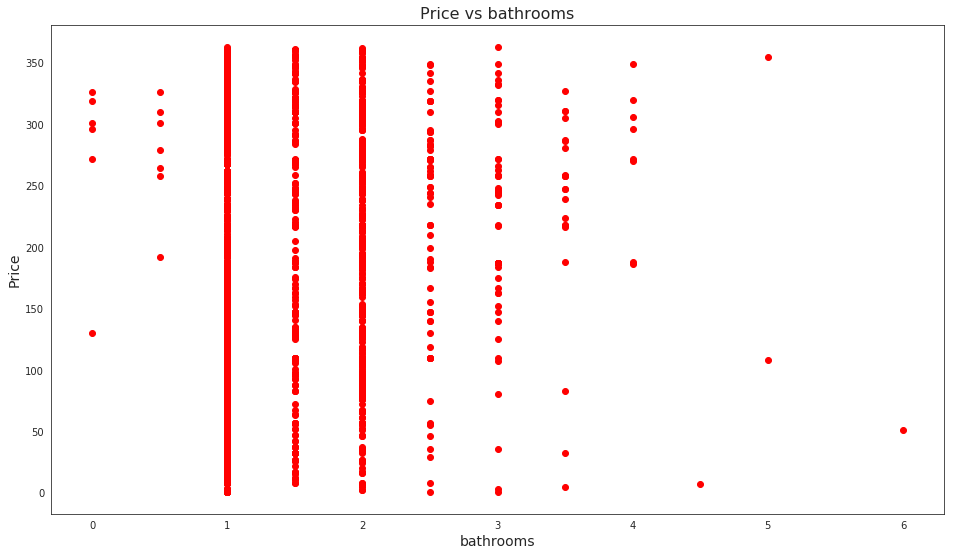

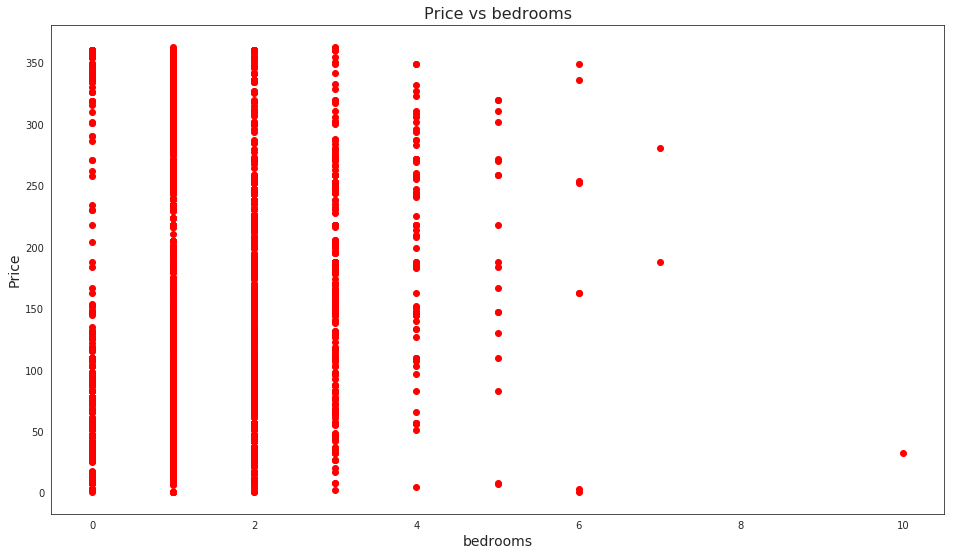

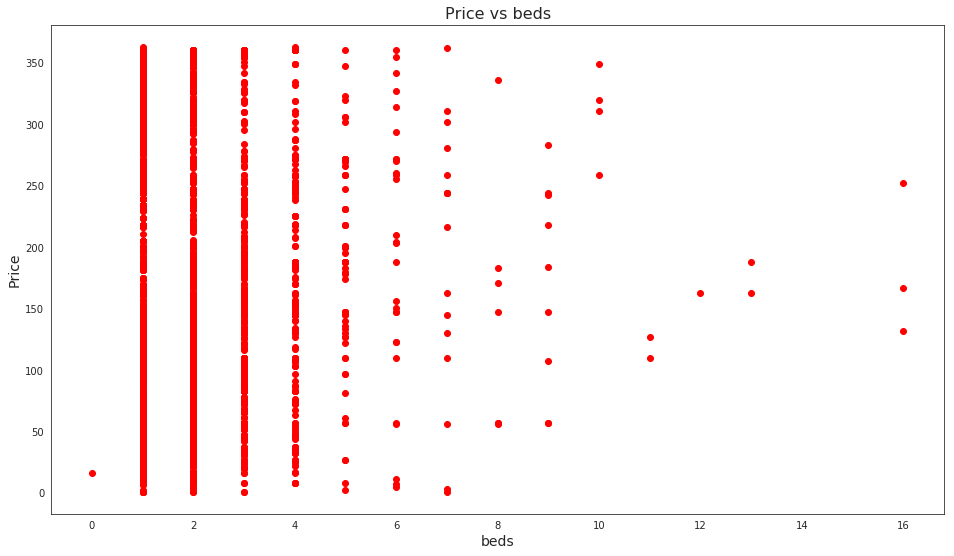

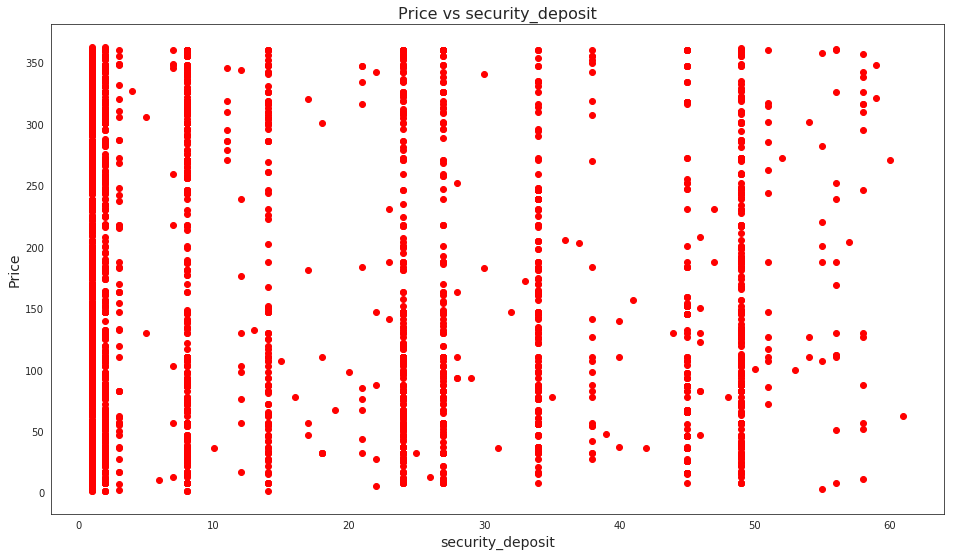

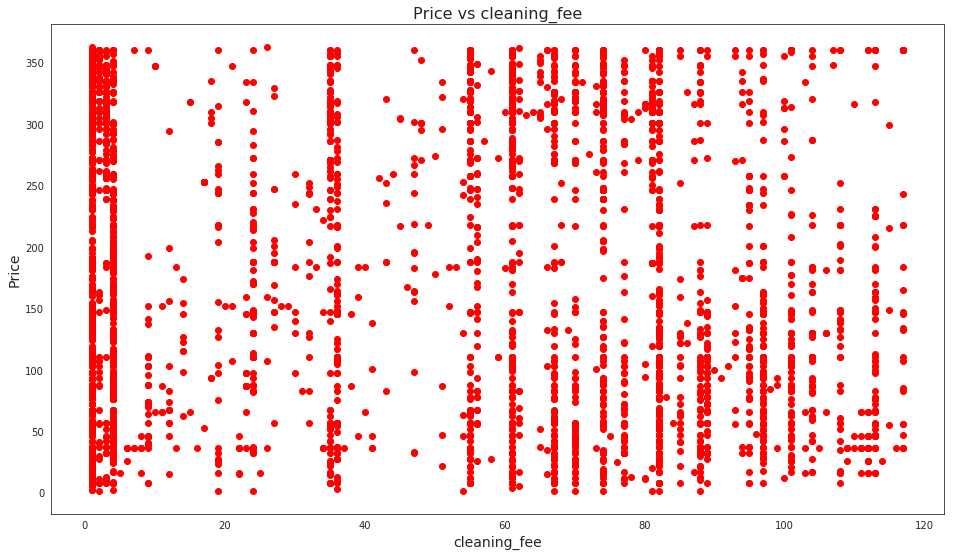

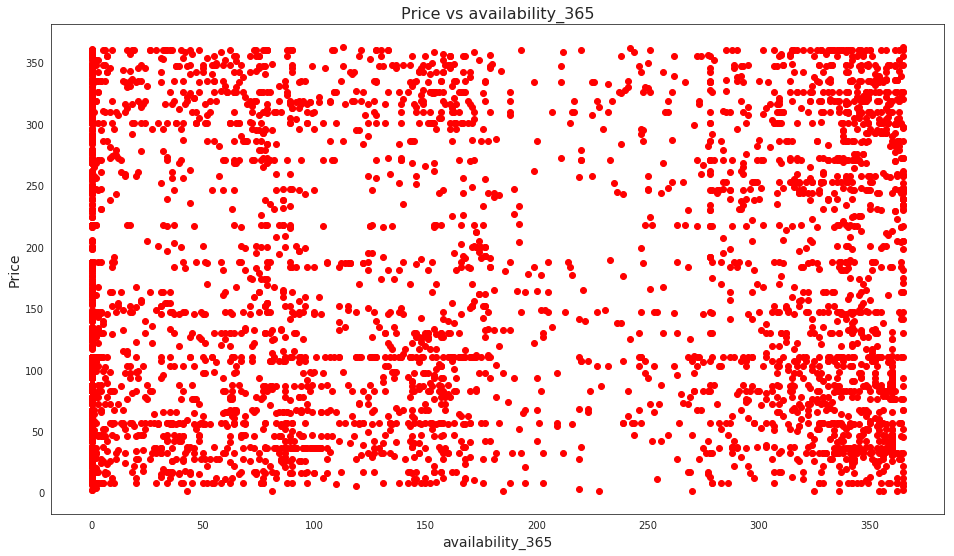

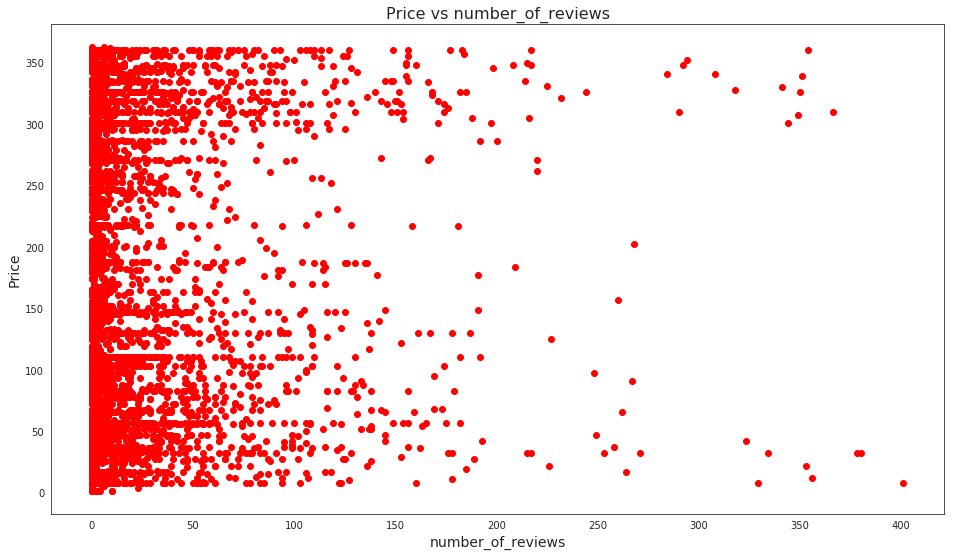

In [165]:
for col in listings_train.columns:
    if col != 'price':
        with sns.axes_style("white"):
            fig, ax = plt.subplots(1, 1, figsize=(16, 9))
            ax.scatter(listings_train[col], listings_train['price'], color = 'red')
            ax.set_xlabel(col, fontsize=14)
            ax.set_ylabel('Price', fontsize=14)
            title = 'Price vs ' + col
            ax.set_title(title, fontsize=16)

From the above plots, it is very apparent that theere are compelx relationships between the response variable - price - and the predictor/depended/feature variables. 

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial baseis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [219]:
from sklearn.linear_model import LinearRegression

#### Linear Regression

In [220]:
# prepare data
#train 
X_train = listings_train.copy()
y_train = X_train['price']
X_train.drop('price', axis=1, inplace=True)
X_train = pd.get_dummies(X_train, drop_first=True, columns=['room_type'])

#test
X_test = listings_test.copy()
y_test = X_test['price']
X_test.drop('price', axis=1, inplace=True)
X_test = pd.get_dummies(X_test, drop_first=True, columns=['room_type'])

In [221]:
# fit linear model
lin_reg = LinearRegression().fit(X_train, y_train)

In [222]:
# predict 
lin_reg_pred = lin_reg.predict(X_test)

In [224]:
# calculate r2 of the linear regression model
lin_reg_r2 = r2_score(y_test, lin_reg_pred)
print(lin_reg_r2)

0.18479127231124737


#### Regression with polynomial baseis functions of degree 3

In [225]:
quant = list(listings_train.columns)
quant.remove('room_type')
quant.remove('price')

In [226]:
for var in quant:
    str_2 = var+'^2'
    str_3 = var+'^3'
    X_train[str_2] = listings_train[var]**2
    X_train[str_3] = listings_train[var]**3
    
    X_test[str_2] = listings_train[var]**2
    X_test[str_3] = listings_train[var]**3

In [227]:
# fit linear poly model
lin_reg_poly = LinearRegression().fit(X_train, y_train)

In [233]:
# predict 
lin_reg_poly_pred = lin_reg_poly.predict(X_test)

In [234]:
# calculate r2 of the linear poly regression model
lin_reg_poly_r2 = r2_score(y_test, lin_reg_poly_pred)
print(lin_reg_poly_r2)

-1.0792560145221262


We see that the linear regression with polynomial baseis functions of degree 3 actually perfroms a lot worse than the straight linear regression model. Intuitively, this makes sense. Although the predictors do not have relationships with the response variable that can best be depicted as linear, the relationships are not best described as polynomial. There is a more complex relationship between the response variable with each of the predictor variables. 

### Part 2b: Generalized Additive Model (GAM)

*Helpful Hint:  Please refer to the lecture ipynb for the code template to perform GAM*

Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


In [72]:
listings_train.head()

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38
2,6,Entire home/apt,42.341902,-71.073792,1.0,1,1,67,45,56,322,9
3,1,Entire home/apt,42.319235,-71.105016,2.0,2,2,103,8,113,341,49
4,1,Entire home/apt,42.346452,-71.134896,1.0,0,1,8,24,82,41,13


In [5]:
gam_s = list(listings_train.columns)
gam_s.remove('price')
gam_s

['host_total_listings_count',
 'room_type',
 'latitude',
 'longitude',
 'bathrooms',
 'bedrooms',
 'beds',
 'security_deposit',
 'cleaning_fee',
 'availability_365',
 'number_of_reviews']

In [6]:
r_gam_lib = importr('gam')
r_gam = r_gam_lib.gam

In [13]:
# cross validation to find the number of knots 
spars = [.01,.2,.4,.6,.8,.9,.99]
kf = KFold(n_splits=5) 
d_spars = {}
model = 0
model_score = 0
for i in spars:
    scores = []
    
    # string
    string_gam = 'price~'
    for var in gam_s:
        if var == 'room_type':
            string_gam = string_gam + '{}+'.format(var)
        else:
            string_gam = string_gam + 's({}, spar={})+'.format(var,i)
    string_gam = string_gam[:-1]

    for train, test in kf.split(listings_train):
        
        X_train = listings_train.loc[train,:]
        X_test = listings_train.loc[test,:]
                
        r_host_total_listings_count = robjects.FloatVector(X_train['host_total_listings_count'].values)
        r_room_type = robjects.FactorVector(X_train['room_type'].values)
        r_latitude = robjects.FloatVector(X_train['latitude'].values)
        r_longitude = robjects.FloatVector(X_train['longitude'].values)
        r_bathrooms = robjects.FloatVector(X_train['bathrooms'].values)
        r_bedrooms = robjects.FloatVector(X_train['bedrooms'].values)
        r_beds = robjects.FloatVector(X_train['beds'].values)
        r_price = robjects.FloatVector(X_train['price'].values)
        r_security_deposit = robjects.FloatVector(X_train['security_deposit'].values)
        r_cleaning_fee = robjects.FloatVector(X_train['cleaning_fee'].values)
        r_availability_365 = robjects.FloatVector(X_train['availability_365'].values)
        r_number_of_reviews = robjects.FloatVector(X_train['number_of_reviews'].values)
        
        # formula 
        gam_formula = robjects.Formula(string_gam)
        gam_formula.environment['price'] = r_price
        gam_formula.environment['host_total_listings_count'] = r_host_total_listings_count
        gam_formula.environment['room_type'] = r_room_type
        gam_formula.environment['latitude'] = r_latitude
        gam_formula.environment['longitude'] = r_longitude
        gam_formula.environment['bathrooms'] = r_bathrooms
        gam_formula.environment['bedrooms'] = r_bedrooms
        gam_formula.environment['beds'] = r_beds
        gam_formula.environment['security_deposit'] = r_security_deposit
        gam_formula.environment['cleaning_fee'] = r_cleaning_fee
        gam_formula.environment['availability_365'] = r_availability_365
        gam_formula.environment['number_of_reviews'] = r_number_of_reviews
        
        # fit
        listings_gam = r_gam(gam_formula,family="gaussian")
        
        # test 
        
        r_host_total_listings_count = robjects.FloatVector(X_test['host_total_listings_count'].values)
        r_room_type = robjects.FactorVector(X_test['room_type'].values)
        r_latitude = robjects.FloatVector(X_test['latitude'].values)
        r_longitude = robjects.FloatVector(X_test['longitude'].values)
        r_bathrooms = robjects.FloatVector(X_test['bathrooms'].values)
        r_bedrooms = robjects.FloatVector(X_test['bedrooms'].values)
        r_beds = robjects.FloatVector(X_test['beds'].values)
        r_price = robjects.FloatVector(X_test['price'].values)
        r_security_deposit = robjects.FloatVector(X_test['security_deposit'].values)
        r_cleaning_fee = robjects.FloatVector(X_test['cleaning_fee'].values)
        r_availability_365 = robjects.FloatVector(X_test['availability_365'].values)
        r_number_of_reviews = robjects.FloatVector(X_test['number_of_reviews'].values)
        
        r_df = robjects.DataFrame({'host_total_listings_count':r_host_total_listings_count,
                           'room_type': r_room_type, 
                           'latitude' : r_latitude,
                           'longitude' : r_longitude,
                           'bathrooms' : r_bathrooms,
                           'bedrooms' : r_bedrooms,
                           'beds' : r_beds,
                           'security_deposit' : r_security_deposit,
                           'cleaning_fee' : r_cleaning_fee,
                           'availability_365' : r_availability_365,
                           'number_of_reviews' : r_number_of_reviews})

        
        # predict
        pred = r_predict(listings_gam,r_df)
        
        # score
        score = r2_score(r_price, pred)
        scores.append(score)
        
        if score > model_score:
            model = listings_gam
        
    #append mean
    d_spars[i] = np.mean(scores)

In [8]:
# string
string_gam = 'price~'
spar = .99
for var in gam_s:
    if var == 'room_type':
        string_gam = string_gam + '{}+'.format(var)
    else:
        string_gam = string_gam + 's({}, spar={})+'.format(var,spar)
string_gam = string_gam[:-1]

X_train = listings_train.copy()
r_host_total_listings_count = robjects.FloatVector(X_train['host_total_listings_count'].values)
r_room_type = robjects.FactorVector(X_train['room_type'].values)
r_latitude = robjects.FloatVector(X_train['latitude'].values)
r_longitude = robjects.FloatVector(X_train['longitude'].values)
r_bathrooms = robjects.FloatVector(X_train['bathrooms'].values)
r_bedrooms = robjects.FloatVector(X_train['bedrooms'].values)
r_beds = robjects.FloatVector(X_train['beds'].values)
r_price = robjects.FloatVector(X_train['price'].values)
r_security_deposit = robjects.FloatVector(X_train['security_deposit'].values)
r_cleaning_fee = robjects.FloatVector(X_train['cleaning_fee'].values)
r_availability_365 = robjects.FloatVector(X_train['availability_365'].values)
r_number_of_reviews = robjects.FloatVector(X_train['number_of_reviews'].values)

# formula 
gam_formula = robjects.Formula(string_gam)
gam_formula.environment['price'] = r_price
gam_formula.environment['host_total_listings_count'] = r_host_total_listings_count
gam_formula.environment['room_type'] = r_room_type
gam_formula.environment['latitude'] = r_latitude
gam_formula.environment['longitude'] = r_longitude
gam_formula.environment['bathrooms'] = r_bathrooms
gam_formula.environment['bedrooms'] = r_bedrooms
gam_formula.environment['beds'] = r_beds
gam_formula.environment['security_deposit'] = r_security_deposit
gam_formula.environment['cleaning_fee'] = r_cleaning_fee
gam_formula.environment['availability_365'] = r_availability_365
gam_formula.environment['number_of_reviews'] = r_number_of_reviews

        
# fit
listings_gam = r_gam(gam_formula,family="gaussian")

# test 

X_test = listings_test.copy()
r_host_total_listings_count = robjects.FloatVector(X_test['host_total_listings_count'].values)
r_room_type = robjects.FactorVector(X_test['room_type'].values)
r_latitude = robjects.FloatVector(X_test['latitude'].values)
r_longitude = robjects.FloatVector(X_test['longitude'].values)
r_bathrooms = robjects.FloatVector(X_test['bathrooms'].values)
r_bedrooms = robjects.FloatVector(X_test['bedrooms'].values)
r_beds = robjects.FloatVector(X_test['beds'].values)
r_price = robjects.FloatVector(X_test['price'].values)
r_security_deposit = robjects.FloatVector(X_test['security_deposit'].values)
r_cleaning_fee = robjects.FloatVector(X_test['cleaning_fee'].values)
r_availability_365 = robjects.FloatVector(X_test['availability_365'].values)
r_number_of_reviews = robjects.FloatVector(X_test['number_of_reviews'].values)

r_df = robjects.DataFrame({'host_total_listings_count':r_host_total_listings_count,
                   'room_type': r_room_type, 
                   'latitude' : r_latitude,
                   'longitude' : r_longitude,
                   'bathrooms' : r_bathrooms,
                   'bedrooms' : r_bedrooms,
                   'beds' : r_beds,
                   'security_deposit' : r_security_deposit,
                   'cleaning_fee' : r_cleaning_fee,
                   'availability_365' : r_availability_365,
                   'number_of_reviews' : r_number_of_reviews})


# predict
pred = r_predict(listings_gam,r_df)

# score
score = r2_score(r_price, pred)
print(score)

0.22611679204678514


We see the gam performing significantly better than the previous models. 

In [18]:
gam_preplot.rx2(gam_preplot.names[0]).rx2('y')

-0.660179,14.499934,1.642734,-0.660179,...,-0.660179,-0.660179,-0.660179,4.633897


In [9]:
r_preplot = robjects.r['preplot']
gam_preplot = r_preplot(listings_gam, resid=True, rug=False)

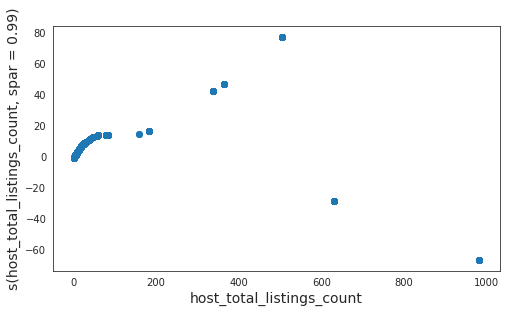

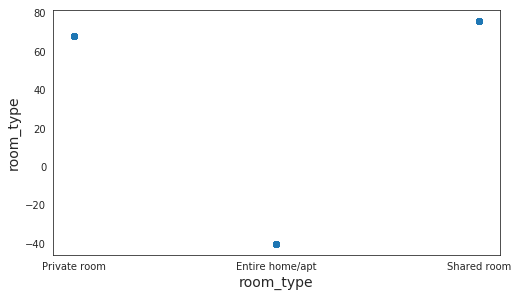

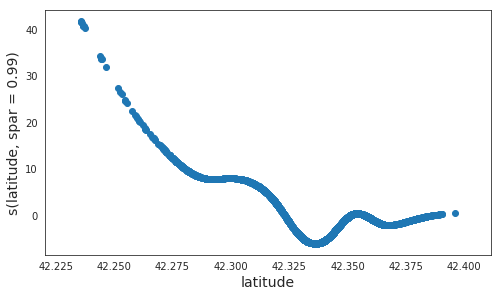

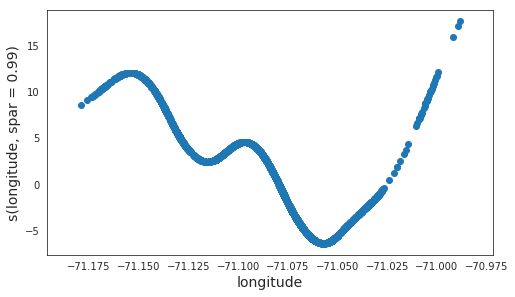

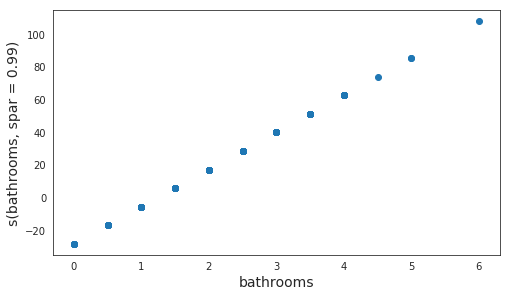

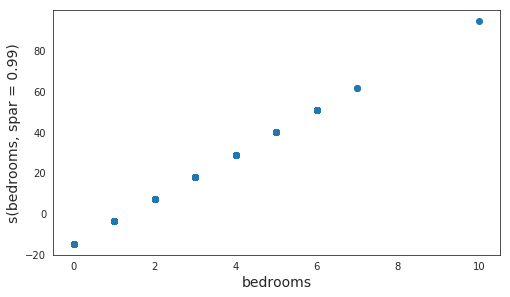

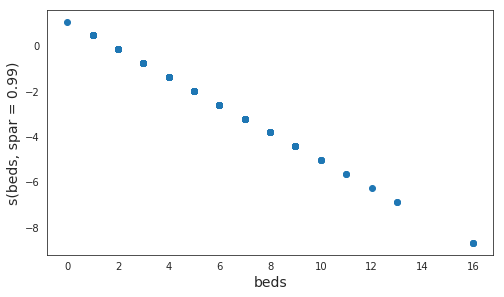

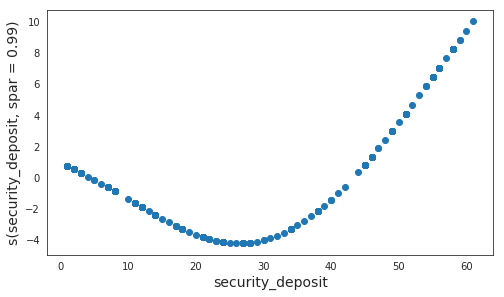

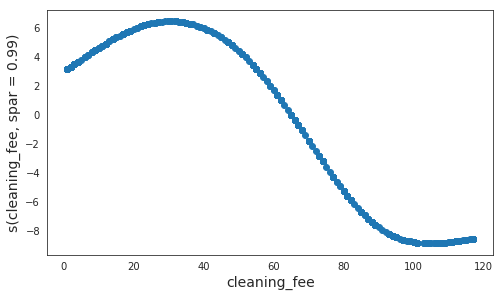

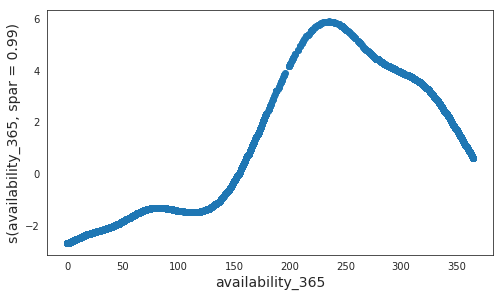

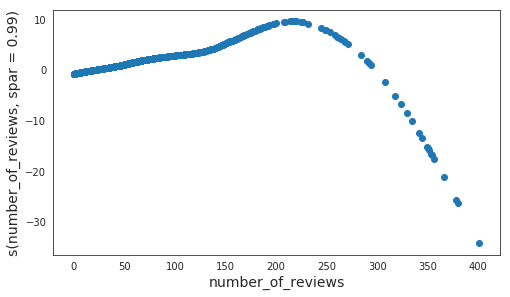

In [21]:
for var, name in zip(gam_s, gam_preplot.names):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
        ax.scatter(X_train[var], gam_preplot.rx2(name)[1])
        ax.set_xlabel(var, fontsize=14)
        ax.set_ylabel(name, fontsize=14)    

The above plots show definite non-linearity in the data and confirm that this model fits the data better than regular linear regression. This is seen in the non-linearity of the plots. 

### Part 2c: Putting it All Together

Based on your analysis for problems 1 and 2, what advice would you give a frugal visitor to Boston looking to save some money on an Airbnb rental?



Avoid visiting with the crowd i.e. do not visit during the Boston marathon, and preferably visit during the weekday 